In [1]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Custom Self-Attention Layer with 1x1 2D Convolutions

Welcome to the documentation for our custom self-attention layer, meticulously designed to enhance your models with self-attention capabilities through the utilization of 1x1 convolutions. This custom layer aims to enrich your models with advanced self-attention capabilities while maintaining the ease of integration that Keras offers.

**Overview:**
This custom layer implementation draws its design principles from the influential SAGAN paper ([Self-Attention Generative Adversarial Networks](https://arxiv.org/abs/1805.08318v2on), which introduced pioneering concepts in self-attention. While originally implemented in PyTorch, we've taken the initiative to translate and adapt this mechanism for Keras (and TensorFlow), enriching it with unique modifications that further elevate its functionality.

**Key Features:**

1. **Versatile Usage:** This custom layer can seamlessly serve as the firts layer within a convolutional model or as an intermediary layer.
2. **Input Flexibility:** When `filters` specifications are omitted, the layer automatically mirrors the input dimensions. For example, if the input is `(batch_size, width, height, channels)` and no `filters` are specified, the output retains the same shape.
3. **Strategic Filtering:** Designed for optimal adaptability, when used as the model's first layer, the number of filters can be customized. This empowers the network to derive diverse insights from the input data before passing this to subsequent convolutional layers. For instance, specifying `filters=8` with an input shape of `(batch_size, 28, 28, 1)` results in an output shape of `(batch_size, 28, 28, 8)`.
4. **Activation Flexibility:** Our custom self-attention layer supports a range of activation functions, allowing you to tailor the layer's behavior to your needs. Choose from activation functions like `relu`, `tanh`, and more. The default activation is set to `linear`.
5. **Attention Control with Gamma:** The custom self-attention layer introduces the `gamma` parameter, which governs the influence of the attention mask on the outputs. While you can set an initial value for Gamma, its final value is learned during the model training process. This parameter provides a dynamic means of adjusting the attention mechanism's impact based on the specific needs of your model.
6. **Attention Score Retrieval:** By setting the `return_attention_scores` parameter to `True`, the custom layer returns the inputs after applying the attention mask and scaling by Gamma. This allows you to access and analyze the attention scores for deeper insights into the model's decision-making process.


**Acknowledgments:**
This implementation has drawn inspiration and learning from the community's contributions. Special thanks to the authors of:

https://github.com/grohith327/simplegan/blob/master/simplegan/layers/selfattention.py
https://github.com/MorvanZhou/mnistGANs/blob/main/sagan.py

These resources have greatly contributed to shaping our implementation.

In [2]:
class SelfAttention_Conv2D(keras.layers.Layer):
    def __init__(self, filters=None, gamma=0.01, activation='linear', return_attention_scores=False, trainable=True):
        super().__init__(trainable=trainable)
        self.gamma = tf.Variable(initial_value=gamma, trainable=True, name='gamma')
        self.f = None
        self.g = None
        self.h = None
        self.v = None
        self.attention = None
        self.c = filters
        self.activation = activation
        self.scores = return_attention_scores

    def build(self, input_shape):
        if self.c is None:
            self.c = input_shape[-1]
        self.f = self.block(self.c)
        self.g = self.block(self.c)
        self.h = self.block(self.c)
        self.v = layers.Conv2D(self.c, 1, 1, activation=self.activation) # output feature maps

    @staticmethod
    def block(c):
        return keras.Sequential([
            layers.Conv2D(c, 1, 1),   # [n, w, h, c] 1*1conv
            layers.Reshape((-1, c)),  # [n, w*h, c]
            ])

    def call(self, inputs, **kwargs):
        f = self.f(inputs)    # [n, w*h, c]
        g = self.g(inputs)    # [n, w*h, c]
        h = self.h(inputs)    # [n, w*h, c]
        s = tf.matmul(f, g, transpose_b=True)   # [n, w*h, c] @ [n, c, w*h] = [n, w*h, w*h]
        self.attention = tf.nn.softmax(s, axis=-1)
        context_wh = tf.matmul(self.attention, h)  # [n, w*h, w*h] @ [n, w*h, c] = [n, w*h, c]
        d = inputs.shape        # [n, w, h, c]
        cs = context_wh.shape   # [n, w*h, c]
        context = self.gamma * tf.reshape(context_wh, [-1, d[1], d[2], cs[-1]])    # [n, w, h, c]
        o = self.v(context) + inputs   # residual

        if self.scores:
            return o, self.attention
        else:
            return o

## Example of use with the MNIST dataset

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Change the data type to a floating point format
x_train = x_train.astype("float32")/255.
x_test = x_test.astype("float32")/255.
x_train = x_train[:,:,:,np.newaxis]
x_test = x_test[:,:,:,np.newaxis]

In [6]:
input = layers.Input((28, 28, 1))
x = SelfAttention_Conv2D(16, activation='relu')(input)
x = layers.Conv2D(32, (5, 5), activation='relu')(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(100, activation="relu")(x)
output = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs=input, outputs=output)

model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=["accuracy"])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 self_attention__conv2d_1 (S  (None, 28, 28, 16)       369       
 elfAttention_Conv2D)                                            
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        12832     
                                                                 
 average_pooling2d_1 (Averag  (None, 12, 12, 32)       0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               4609

## Train the model

In [7]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=3,
                                            restore_best_weights=True)

epochs = 10
batch_size = 128

history = model.fit(x_train,
                    y_train,
                    validation_split=0.2,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[callback]
                    )

Epoch 1/10
375/375 [==============================] - 18s 43ms/step - loss: 0.1746 - accuracy: 0.9467 - val_loss: 0.0630 - val_accuracy: 0.9808
Epoch 2/10
375/375 [==============================] - 17s 45ms/step - loss: 0.0499 - accuracy: 0.9847 - val_loss: 0.0508 - val_accuracy: 0.9835
Epoch 3/10
375/375 [==============================] - 15s 41ms/step - loss: 0.0316 - accuracy: 0.9905 - val_loss: 0.0475 - val_accuracy: 0.9872
Epoch 4/10
375/375 [==============================] - 16s 42ms/step - loss: 0.0212 - accuracy: 0.9935 - val_loss: 0.0432 - val_accuracy: 0.9874
Epoch 5/10
375/375 [==============================] - 17s 44ms/step - loss: 0.0159 - accuracy: 0.9950 - val_loss: 0.0517 - val_accuracy: 0.9863
Epoch 6/10
375/375 [==============================] - 16s 42ms/step - loss: 0.0108 - accuracy: 0.9964 - val_loss: 0.0471 - val_accuracy: 0.9896
Epoch 7/10
375/375 [==============================] - 15s 41ms/step - loss: 0.0081 - accuracy: 0.9975 - val_loss: 0.0481 - val_accuracy:

## Visualize results

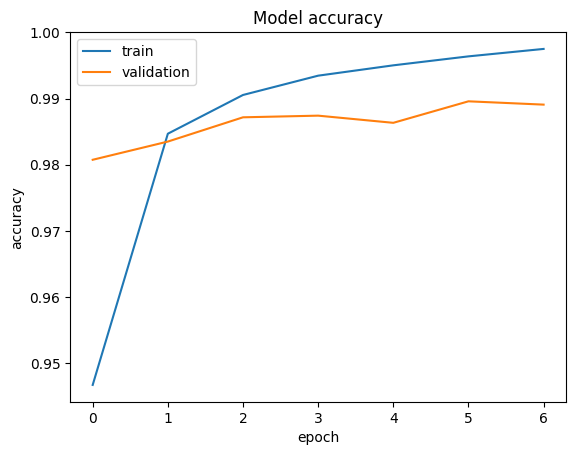

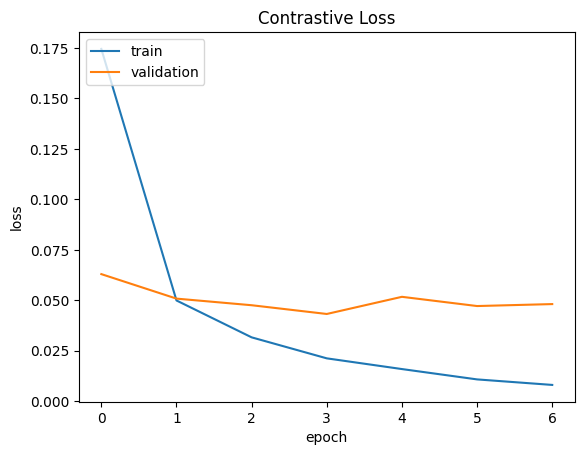

In [8]:
def plt_metric(history, metric, title, has_valid=True):
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the contrastive loss
plt_metric(history=history.history, metric="loss", title="Contrastive Loss")

## Evaluate the model

In [9]:
results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)

313/313 [==============================] - 2s 7ms/step - loss: 0.0401 - accuracy: 0.9884
test loss, test acc: [0.04010656476020813, 0.9883999824523926]
